**Содержание:**
* [Подключение библиотек и загрузка данных](#start)
* [Обзор датасета](#review)
* [Обработка выбросов](#outliers)
* [Обработка пропусков](#gaps)
* [Категориальные признаки](#categorical_features)
*[Модель](#model)

### Подключение библиотек и загрузка данных <a class="anchor" id="start">

In [3]:
import numpy as np
import pandas as pd
import pickle

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
import xgboost as xgb
import catboost as catb

#from sklearn.model_selection import xgboost as xgb, lightgbm as lgbm, catboost as catb

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler


import random
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

DATASET_PATH = 'course_project_test.csv'
PREP_DATASET_PATH = 'course_project_train.csv'
df_base = pd.read_csv(DATASET_PATH)
df = pd.read_csv(PREP_DATASET_PATH)

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
def balance_df_by_target(df, target_name):
    target_counts = df[target_name].value_counts()
    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()
    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name])
    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)
    return df.sample(frac=1)
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()
#df.info()
#df = df_base.copy()

### Обзор датасета <a class="anchor" id="review">

####    Обзор целевой переменной

In [4]:
print (f"Число '0' = {df.loc[(df['Credit Default']==0), 'Credit Default'].count()}, число '1' {df.loc[(df['Credit Default']==1), 'Credit Default'].count()}.")
print (f"Пропусков - {df['Credit Default'].count() - (df.loc[(df['Credit Default']==0), 'Credit Default'].count() + df.loc[(df['Credit Default']==1), 'Credit Default'].count())}")

Число '0' = 5387, число '1' 2113.
Пропусков - 0


#### Тепловая карта корреляций признаков

In [5]:
# plt.figure(figsize = (15,10))

# sns.set(font_scale=1.8)
# sns.heatmap(df.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

# plt.title('Correlation matrix')
# plt.show()

####    Анализ выбросов

<AxesSubplot:xlabel='variable', ylabel='value'>

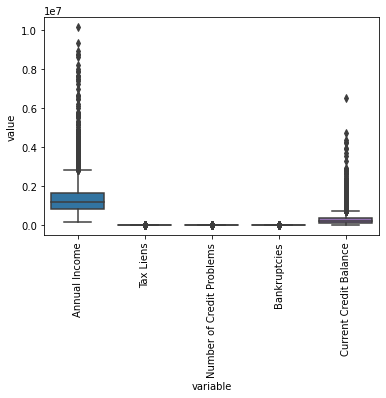

In [6]:
# Построим boxplot по всем числовым признакам
#df_tmp = pd.DataFrame(data=df, columns=['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score'])
# Последовательно исключая (визуально) признаки с наибольшими выбросами, получим такую классификацию по их величине:
# 'Maximum Open Credit' - ну очень большие выбросы (предположительно не нормальное распр.)
# 'Current Loan Amount' - ну очень большие выбросы (предположительно не нормальное распр.)
df_tmp = pd.DataFrame(data=df, columns=['Annual Income', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies', 'Current Credit Balance'])
bp1 = sns.boxplot(x="variable", y="value", data=pd.melt(df_tmp))
bp1.set_xticklabels(bp1.get_xticklabels(),rotation=90)
bp1

# 'Annual Income' - очень большие выбросы
# 'Current Credit Balance' - очень большие выбросы
# 'Monthly Debt' - большие выбросы
# 'Credit Score' - заметные выбросы
# 'Number of Open Accounts', 'Years of Credit History', 'Months since last delinquent' - просто выбросы

# df_tmp.head()
# df[['Current Loan Amount', 'Maximum Open Credit']]
# df['Bankruptcies'].hist(bins=10)

### Обработка выбросов <a class="anchor" id="outliers">

#####    Maximum Open Credit - обработка выбросов

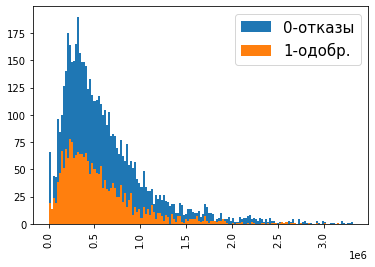

В диапазоне от 0 до 3000000 параметр распределен одинаково для положительных и отрицательных решений.
При этом, если "Maximum Open Credit" больше 3000000, то доля положительных решений:
0.14
что почти в 3 раза меньше, чем в среднем по выборке, а значит экстремально большие значения отбрасывать нельзя.


In [7]:
filter1 = df['Credit Default']==0
filter2 = df['Credit Default']==1

x = df.loc[filter1, 'Maximum Open Credit']
y = df.loc[filter2, 'Maximum Open Credit']

bins = np.linspace(0, df.loc[filter2, 'Maximum Open Credit'].max()/2, 150)
plt.hist(x, bins, label='0-отказы')
plt.hist(y, bins, label='1-одобр.')
plt.xticks(rotation=90)
plt.legend(loc='best', fontsize=15)
plt.show()
print('В диапазоне от 0 до 3000000 параметр распределен одинаково для положительных и отрицательных решений.')
print('При этом, если "Maximum Open Credit" больше 3000000, то доля положительных решений:')
print(round(df.loc[(df['Maximum Open Credit']>3000000)&filter2, 'Maximum Open Credit'].count()/df.loc[(df['Maximum Open Credit']>3000000)&filter1, 'Maximum Open Credit'].count(),2))
print('что почти в 3 раза меньше, чем в среднем по выборке, а значит экстремально большие значения отбрасывать нельзя.')


####    Current Loan Amount - обработка выбросов

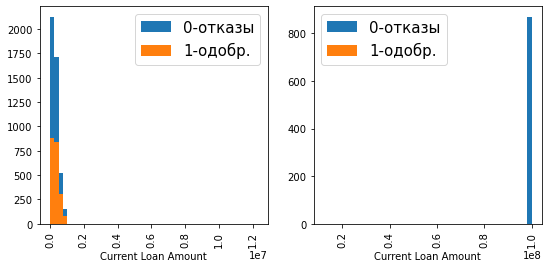

In [8]:
# Распределение явно "не нормальное" построим его отдельно для положительных и отриц. решений
# Визуально по распределениям подберем значение "big_value", которое разграничивает "хорошие" и аномальные данные
plt.figure(figsize=(9, 4))

subpl1=plt.subplot(121)
big_value = df['Current Loan Amount'].quantile(.884)
x = df.loc[((df['Credit Default'] == 0) & (df['Current Loan Amount'] < big_value)), 'Current Loan Amount']
y = df.loc[((df['Credit Default'] == 1) & (df['Current Loan Amount'] < big_value)), 'Current Loan Amount']
bins = np.linspace(0, big_value, 50)
plt.hist(x, bins, label='0-отказы')
plt.hist(y, bins, label='1-одобр.')
subpl1.set_xlabel(xlabel = "Current Loan Amount", fontsize = 10)
subpl1.tick_params(labelsize=10)
plt.xticks(rotation=90)
subpl1.legend(loc='best', fontsize=15)

subpl2=plt.subplot(122)
big_value = df['Current Loan Amount'].quantile(.884)
x = df.loc[((df['Credit Default'] == 0) & (df['Current Loan Amount'] > big_value)), 'Current Loan Amount']
y = df.loc[((df['Credit Default'] == 1) & (df['Current Loan Amount'] > big_value)), 'Current Loan Amount']
bins = np.linspace(big_value, df['Current Loan Amount'].quantile(1), 50)
plt.hist(x, bins, label='0-отказы')
plt.hist(y, bins, label='1-одобр.')
subpl2.set_xlabel(xlabel = "Current Loan Amount", fontsize = 10)
subpl2.tick_params(labelsize=10)
plt.xticks(rotation=90)
subpl2.legend(loc='best', fontsize=15)

plt.show()


In [9]:
#df.loc[(df['Current Loan Amount'] > big_value), 'Current Loan Amount'].describe()
# Похоже, что значения 1.000000e+08 - ошибки, заменяем с помощью интерполяции
filter3 = df['Current Loan Amount'] > big_value*0.9
filter4 = df['Current Loan Amount'] < big_value*0.9
df.loc[filter3,'Current Loan Amount'] = np.NaN
df['Current Loan Amount'] = df['Current Loan Amount'].interpolate(method='linear')
mean_val = df.loc[(filter4),'Current Loan Amount'].mean()
df['Current Loan Amount'] = df['Current Loan Amount'].fillna(mean_val)
df['Current Loan Amount'].describe()

count      7500.000000
mean     308823.988185
std      177113.104792
min       11242.000000
25%      176060.500000
50%      267448.500000
75%      421635.500000
max      789030.000000
Name: Current Loan Amount, dtype: float64

#####     Annual Income - обработка выбросов

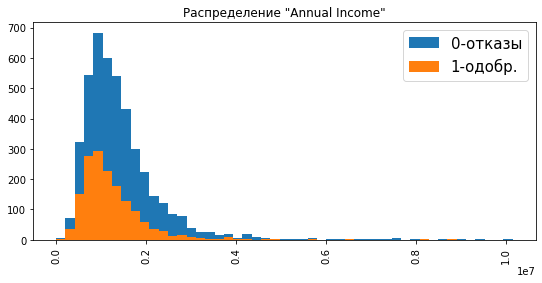

In [10]:
filter5 = df['Credit Default']==0
filter6 = df['Credit Default']==1

plt.figure(figsize=(9, 4))
plt.title('Распределение "Annual Income"')

x = df.loc[filter5, 'Annual Income']
y = df.loc[filter6, 'Annual Income']

bins = np.linspace(0, df['Annual Income'].max(), 50)
plt.hist(x, bins, label='0-отказы')
plt.hist(y, bins, label='1-одобр.')
plt.xticks(rotation=90)
plt.legend(loc='best', fontsize=15)
plt.show()

In [11]:
# вероятно, все что больше 4 000 000 - выбросы - заменяем на NaN, позже обработаем вместе с пропусками:
filter7 = df['Annual Income'] > 4000000
df.loc[filter7,'Annual Income'] = np.NaN
#df['Annual Income'].describe()

#####     Current Credit Balance - обработка выбросов

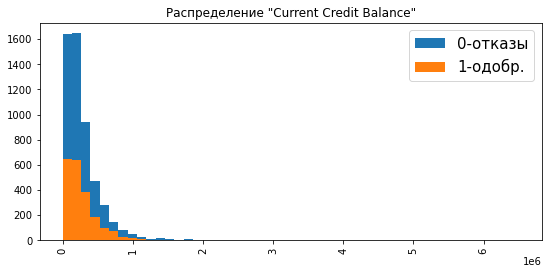

In [12]:
# #Current Credit Balance
filter1 = df['Credit Default']==0
filter2 = df['Credit Default']==1
plt.figure(figsize=(9, 4))
plt.title('Распределение "Current Credit Balance"')
x = df.loc[filter1, 'Current Credit Balance']
y = df.loc[filter2, 'Current Credit Balance']
bins = np.linspace(0, df['Current Credit Balance'].max(), 50)
plt.hist(x, bins, label='0-отказы')
plt.hist(y, bins, label='1-одобр.')
plt.xticks(rotation=90)
plt.legend(loc='best', fontsize=15)
plt.show()

# Отбрасываем хвост, заменяя на интерполированные значения
filter8 = df['Current Credit Balance'] > 1200000

df.loc[filter8,'Current Credit Balance'] = np.NaN
df['Current Credit Balance'] = df['Current Credit Balance'].interpolate(method='linear')

filter8 = df['Current Credit Balance'] < 1200000
mean_val = df.loc[(filter8),'Current Credit Balance'].mean()
df['Current Credit Balance'] = df['Current Credit Balance'].fillna(mean_val)
#df['Current Credit Balance'].describe()

#####   Monthly Debt  - обработка выбросов

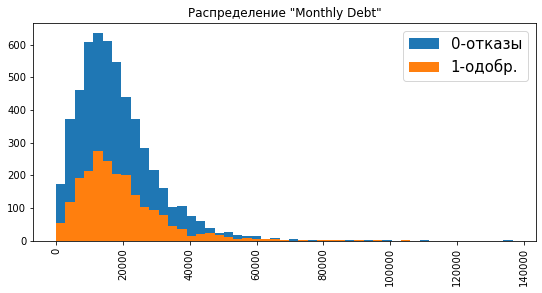

In [13]:
# Monthly Debt - аналогично Current Credit Balance
str_name = 'Monthly Debt'
big_value = 65000
filter1 = df['Credit Default']==0
filter2 = df['Credit Default']==1
plt.figure(figsize=(9, 4))
plt.title('Распределение "'+str_name+'"')
x = df.loc[filter1, str_name]
y = df.loc[filter2, str_name]
bins = np.linspace(0, df[str_name].max(), 50)
plt.hist(x, bins, label='0-отказы')
plt.hist(y, bins, label='1-одобр.')
plt.xticks(rotation=90)
plt.legend(loc='best', fontsize=15)
plt.show()
# Отбрасываем хвост, заменяя на интерполированные значения
filter8 = df[str_name] > big_value
df.loc[filter8,str_name] = np.NaN
df[str_name] = df[str_name].interpolate(method='linear')
filter8 = df[str_name] < big_value
mean_val = df.loc[(filter8), str_name].mean()
df[str_name] = df[str_name].fillna(mean_val)

#####   Credit Score  - обработка выбросов

In [14]:
# Credit Score  - изучив распределение видем, что есть две выборки значений
filter_1 = (df['Credit Score']>=500)&(df['Credit Score']<=850)&(df['Credit Default']==0)
filter_2 = (df['Credit Score']>=500)&(df['Credit Score']<=850)&(df['Credit Default']==1)
filter_3 = (df['Credit Score']>=5000)&(df['Credit Score']<=8500)&(df['Credit Default']==0)
filter_4 = (df['Credit Score']>=5000)&(df['Credit Score']<=8500)&(df['Credit Default']==1)
group_1 = df.loc[filter_1, 'Credit Score'].count()
group_2 = df.loc[filter_2, 'Credit Score'].count()
group_3 = df.loc[filter_3, 'Credit Score'].count()
group_4 = df.loc[filter_4, 'Credit Score'].count()
print(f"Количество записей в группe 1: {group_1}")
print(f"Количество записей в группe 2: {group_2}")
print(f"Количество записей в группe 3: {group_3}")
print(f"Количество записей в группe 4: {group_4}")
# Причем в первой пропорция решений "0" и "1" примерно такая же, как по обществу вцелом, а во второй только "положительные" решения
# Третью образуют отсутствующие значения
# Т.е. этот признак по сути категориальный, чаменяем значения на "0", "1" и "2"
filter_1 = (df['Credit Score']>=500)&(df['Credit Score']<=850)
filter_3 = (df['Credit Score']>=5000)&(df['Credit Score']<=8500)&(df['Credit Default']==0)
df.loc[(df['Credit Score'].isna()), 'Credit Score'] = 0
df.loc[(filter_1|filter_2), 'Credit Score'] = 1
df.loc[(filter_3|filter_4), 'Credit Score'] = 2
df.loc[(df['Credit Score'] > 2), 'Credit Score'] = 0
#df['Credit Score'].value_counts()

Количество записей в группe 1: 4359
Количество записей в группe 2: 1184
Количество записей в группe 3: 0
Количество записей в группe 4: 400


##### Number of Open Accounts и Years of Credit History - обработка выбросов

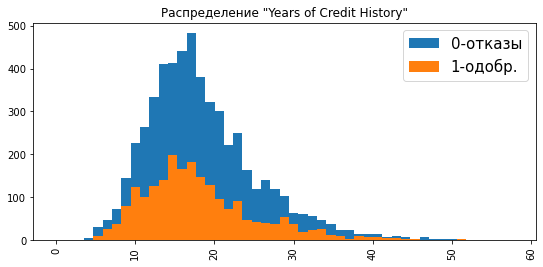

7500

In [15]:
# Number of Open Accounts и/или Years of Credit History - аналогично Current Credit Balance
str_name = 'Years of Credit History'
filter1 = df['Credit Default']==0
filter2 = df['Credit Default']==1
plt.figure(figsize=(9, 4))
plt.title('Распределение "'+str_name+'"')
x = df.loc[filter1, str_name]
y = df.loc[filter2, str_name]
bins = np.linspace(0, df[str_name].max(), 50)
plt.hist(x, bins, label='0-отказы')
plt.hist(y, bins, label='1-одобр.')
plt.xticks(rotation=90)
plt.legend(loc='best', fontsize=15)
plt.show()
# Отбрасываем хвост, заменяя на интерполированные значения
filter8 = df[str_name] > big_value
df.loc[filter8,str_name] = np.NaN
df[str_name] = df[str_name].interpolate(method='linear')
filter8 = df[str_name] < big_value
mean_val = df.loc[(filter8), str_name].mean()
df[str_name] = df[str_name].fillna(mean_val)
df['Years of Credit History'].count()
# По сути это не выбросы, а величины распределенные по закону с более "тяжелым" правым хвостом - ничего не меняем

##### Months since last delinquent

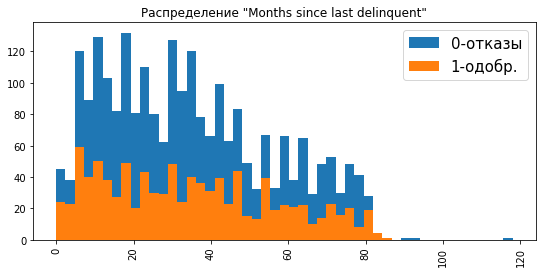

In [16]:
# Выбросов нет, при этом много пропусков (~50%), корреляций с другими признаками неn,
# зависимость результата от этого признака не прослеживается... Кажется, его нужно просто исключить
str_name = 'Months since last delinquent'
filter1 = df['Credit Default']==0
filter2 = df['Credit Default']==1
plt.figure(figsize=(9, 4))
plt.title('Распределение "'+str_name+'"')
x = df.loc[filter1, str_name]
y = df.loc[filter2, str_name]
bins = np.linspace(0, df[str_name].max(), 50)
plt.hist(x, bins, label='0-отказы')
plt.hist(y, bins, label='1-одобр.')
plt.xticks(rotation=90)
plt.legend(loc='best', fontsize=15)
plt.show()

### Обработка пропусков <a class="anchor" id="gaps">

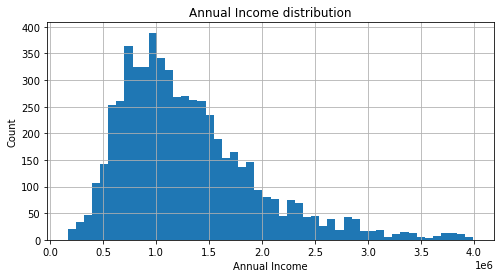

In [17]:
# df.describe()
# Пропуски в Annual Income и Bankruptcies
#df.loc[(df['Bankruptcies']).isna()] Пропусков в "Bankruptcies" мало (~0,2%) и они визуально не отличаются ничем особенным
# просто заменяем нулями
df.loc[(df['Bankruptcies']).isna(),'Bankruptcies'] = 0

# Annual Income - пропусков > 20%
# Построим распределение этого параметра:

plt.figure(figsize = (8, 4))
df['Annual Income'].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Annual Income')
plt.title('Annual Income distribution')
plt.show()


Распределение параметра "Annual Income" явно отличается от нормального, при этом пропусков много, просто выбросить их нельзя.
Есть заметная корреляция с параметром 'Monthly Debt' (диаргамма рассеивания "не очень", но это лучше чем ничего),
поэтому недостающие значения "Annual Income" заполним c помощью медианного коэффициента пропорциональности между этими двумя параметрами, вычислив его и очистив от выбросов:

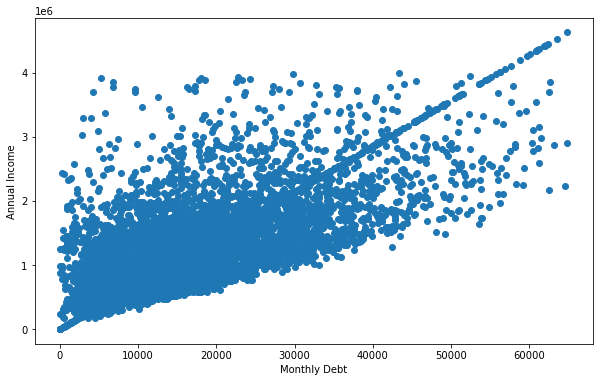

In [18]:
df_tmp = pd.DataFrame()
filter1 = df['Annual Income'].notnull()&df['Monthly Debt']>0
df_tmp = df.loc[filter1,'Annual Income'] / df.loc[filter1,'Monthly Debt']
#df_tmp.describe()
filter2 = (df_tmp < df_tmp.quantile(0.95))&(df_tmp > df_tmp.quantile(0.05))
AI_MD_koef = df_tmp.loc[filter2].median()

filter3 = df['Annual Income'].isnull()
df['Annual Income'].loc[filter3] = df['Monthly Debt'].loc[filter3] * AI_MD_koef
fig, AI_MD = plt.subplots(figsize=(10, 6))
AI_MD.scatter(x = df['Monthly Debt'], y = df['Annual Income'])
plt.xlabel("Monthly Debt")
plt.ylabel("Annual Income")
plt.show()

### Категориальные признаки <a class="anchor" id="categorical_features">

#### Years in current job

In [19]:
# Заменяем категории на числа
# Пропусков около 5%, оформляем их как одну из категорий
Y_list = df['Years in current job'].value_counts().index.tolist()
i=0
for Years in Y_list:
    i += 1
    df.loc[(df['Years in current job'] == Years), 'Years in current job'] = i
filter_n = df['Years in current job'].isnull()
df.loc[filter_n, 'Years in current job'] = i+1
df['Years in current job'] = df['Years in current job'].astype('int8')
# df['Years in current job'].value_counts()

#### Home Ownership

In [20]:
# Home Ownership - пропусков нет
# print(df['Home Ownership'].value_counts())
# - выбросов нет, но, кажется, "Home Mortgage" и "Have Mortgage" это одно и тоже, заменяем второе значение на первое.
df.loc[(df['Home Ownership'] == "Have Mortgage"), 'Home Ownership'] = "Home Mortgage"
df.loc[(df['Home Ownership'] == 'Home Mortgage'), 'Home Ownership'] = 0
df.loc[(df['Home Ownership'] == 'Rent'), 'Home Ownership'] = 1
df.loc[(df['Home Ownership'] == 'Own Home'), 'Home Ownership'] = 2
df['Home Ownership'] = df['Home Ownership'].astype('int8')
#df['Home Ownership'].value_counts()

#### Term

In [21]:
# Заменяем категории на числа
Y_list = df['Term'].value_counts().index.tolist()
i=0
for Years in Y_list:
    i += 1
    df.loc[(df['Term'] == Years), 'Term'] = i
filter_n = df['Term'].isnull()
df.loc[filter_n, 'Term'] = i+1
df['Term'] = df['Term'].astype('int8')
#df['Term'].value_counts()


#### Purpose

In [22]:
# Заменяем категории на числа
Y_list = df['Purpose'].value_counts().index.tolist()
i=0
for Years in Y_list:
    i += 1
    df.loc[(df['Purpose'] == Years), 'Purpose'] = i
filter_n = df['Purpose'].isnull()
df.loc[filter_n, 'Purpose'] = i+1
#df['Purpose'].value_counts()
df['Purpose'] = df['Purpose'].astype('int8')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   int8   
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   int8   
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   int8   
 11  Term                          7500 non-null   int8   
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

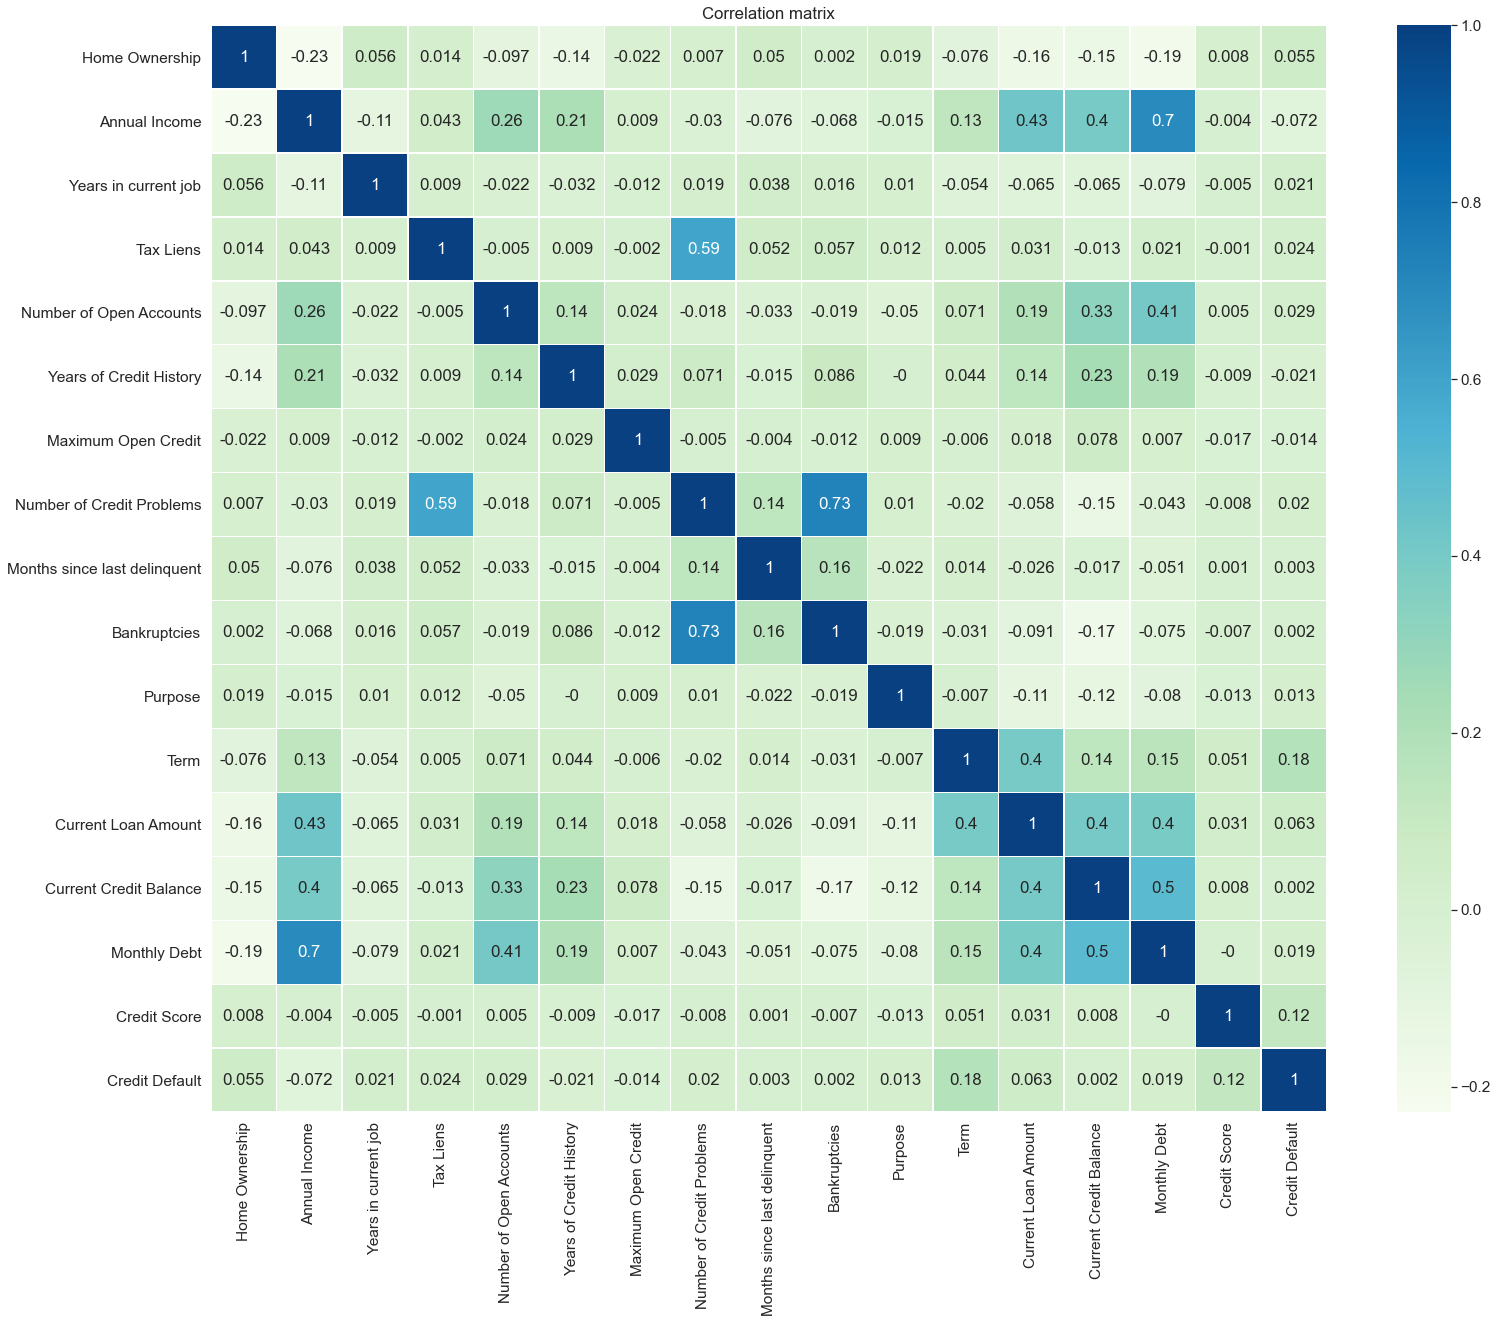

In [23]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show()


### Модель <a class="anchor" id="model">

In [24]:
# df = pd.read_csv(TRAIN_FULL_PATH)
# df_train = pd.read_csv(TRAIN_PART_PATH)
# df_test = pd.read_csv(TEST_PART_PATH)

#### Выделение признакового описания и целевой переменной

In [25]:
# Список скоректирован после анализа важноси признаков
TARGET_NAME = 'Credit Default'
# FEATURE_NAMES = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts',
#                      'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies', 'Purpose', 
#                      'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']
FEATURE_NAMES = ['Home Ownership', 'Annual Income', 'Years in current job', 'Number of Open Accounts',
                      'Years of Credit History', 'Maximum Open Credit', 'Purpose', 
                      'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']



#### Нормализация данных

In [26]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[FEATURE_NAMES] = scaler.fit_transform(df_norm[FEATURE_NAMES])

df = df_norm.copy()

In [27]:
X = df[FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, random_state=17)

df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]


In [28]:
# Протестировал: LogisticRegression, KNeighborsClassifier, XGBClassifie
# Остановился на CatBoostClassifier

In [29]:
model_catb = catb.CatBoostClassifier(n_estimators = 400, max_depth = 9, l2_leaf_reg=10, silent=True, random_state=17)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

#get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
print('TEST\n\n' + classification_report(y_test, y_test_pred))

TEST

              precision    recall  f1-score   support

           0       0.81      0.80      0.80      1604
           1       0.51      0.54      0.52       646

    accuracy                           0.72      2250
   macro avg       0.66      0.67      0.66      2250
weighted avg       0.72      0.72      0.72      2250



In [30]:
with open('model_catb.pkl','wb') as f:
    pickle.dump(model_catb,f)

In [31]:
# %%time
# #params = {'n_estimators':[150, 200, 250],
# #params = {'n_estimators':[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600],          
# params = {'n_estimators':[220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460],
# #           'max_depth':[7, 9]}
#                      'max_depth':[9]}
# cv=KFold(n_splits=3, shuffle=True)
# rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_iter=10, n_jobs=-1)
# rs.fit(X, y)
# rs.best_params_
# rs.best_score_

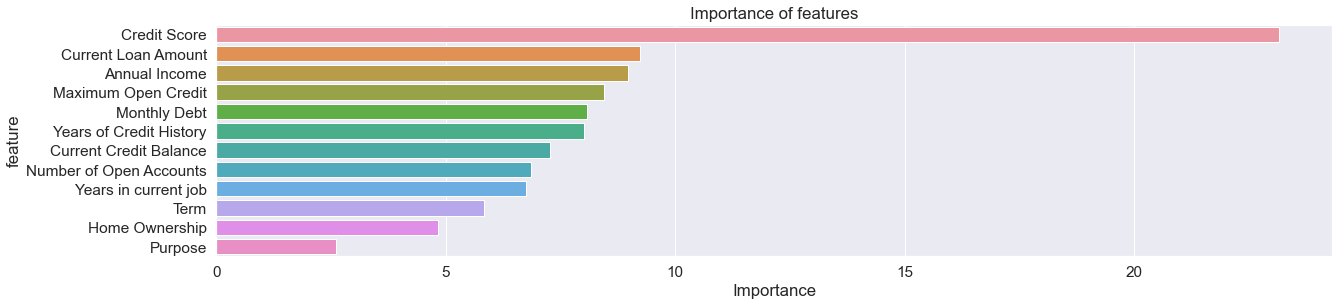

In [32]:
important_features_top = show_feature_importances(X_train.columns, model_catb.feature_importances_, get_top=15)

In [33]:
with open('model_catb.pkl', 'rb') as f:
    model_catb_final = pickle.load(f)

#model_catb.predict(X_test)